# Artificial Neural Networks for Transit Curve Classification

Describes the structure of the neural network (layers, neurons,activation functions, etc...). Discuss the training process: the optimiser and loss function. Show the results from different configurations similarly to what you did in the SVM case

In [2]:
import pandas as pd
import numpy as np
from scipy import ndimage, fft
from sklearn.preprocessing import normalize, StandardScaler
import tensorflow as tf
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt


In [33]:
class LightFluxProcessor:
    """Process light flux data with various signal processing techniques."""

    def __init__(self, fourier=True, normalize=True, gaussian=True, standardize=True):
        """Initialize processor with desired transformations.
        
        Args:
            fourier: Apply Fourier transform if True
            normalize: Apply normalization if True
            gaussian: Apply Gaussian filtering if True
            standardize: Apply standardization if True
        """
        self.fourier = fourier
        self.normalize = normalize
        self.gaussian = gaussian
        self.standardize = standardize

    def fourier_transform(self, data):
        """Apply Fast Fourier Transform to 1D time series data.
        
        Args:
            data: Time series data
            
        Returns:
            Magnitude of FFT result
        """
        return np.abs(fft.fft(data, n=data.size))

    def process(self, train_features, dev_features):
        """Process training and development datasets with selected transformations.
        
        Args:
            train_features: Training features DataFrame
            dev_features: Development features DataFrame
            
        Returns:
            Tuple of processed (train_features, dev_features)
        """
        # Apply Fourier transform
        if self.fourier:
            print("Applying Fourier...")
            train_shape = train_features.shape
            dev_shape = dev_features.shape
            
            # Apply FFT to each row
            train_features = train_features.apply(self.fourier_transform, axis=1)
            dev_features = dev_features.apply(self.fourier_transform, axis=1)

            # Convert Series of arrays back to DataFrame
            train_processed = np.zeros(train_shape)
            dev_processed = np.zeros(dev_shape)

            for idx, row in enumerate(train_features):
                train_processed[idx] = row

            for idx, row in enumerate(dev_features):
                dev_processed[idx] = row

            train_features = pd.DataFrame(train_processed)
            dev_features = pd.DataFrame(dev_processed)

            # Use only first half of FFT output (symmetric data)
            train_features = train_features.iloc[:, :(train_features.shape[1] // 2)].values
            dev_features = dev_features.iloc[:, :(dev_features.shape[1] // 2)].values

        # Normalize data
        if self.normalize:
            print("Normalizing...")
            train_features = pd.DataFrame(normalize(train_features))
            dev_features = pd.DataFrame(normalize(dev_features))

        # Apply Gaussian smoothing
        if self.gaussian:
            print("Applying Gaussian Filter...")
            train_features = ndimage.gaussian_filter(train_features, sigma=10)
            dev_features = ndimage.gaussian_filter(dev_features, sigma=10)

        # Standardize features
        if self.standardize:
            print("Standardizing...")
            scaler = StandardScaler()
            train_features = scaler.fit_transform(train_features)
            dev_features = scaler.transform(dev_features)

        print("Finished Processing!")
        return train_features, dev_features


def build_network(input_shape, version=1):
    """Build a simple binary classification neural network.
    
    Args:
        input_shape: Shape of input features
        
    Returns:
        Compiled Keras model
    """
    
    if version == 1:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(input_shape),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ])
    elif version == 2:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(input_shape),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ])
    
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
    return model


def np_X_Y_from_df(dataframe):
    """Convert DataFrame to numpy arrays for features and binary labels.
    
    Args:
        dataframe: DataFrame containing features and LABEL column
        
    Returns:
        Tuple of (features_array, labels_array) with labels converted to binary
    """
    # Shuffle data for better training
    dataframe = shuffle(dataframe)
    
    # Extract features and labels
    features = dataframe.drop(["LABEL"], axis=1)
    features_array = np.array(features)
    
    # Convert labels to binary (True where LABEL==2)
    raw_labels = np.array(dataframe["LABEL"]).reshape((len(dataframe["LABEL"]), 1))
    binary_labels = raw_labels == 2
    
    return features_array, binary_labels


def plot_model_history(history):
    """
    Visualize model training history with enhanced styling.
    
    Args:
        history: Keras history object containing training metrics
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], 'o-', linewidth=2, markersize=4, color='#2978A0')
    if 'val_accuracy' in history.history:
        ax1.plot(history.history['val_accuracy'], 'o-', linewidth=2, markersize=4, color='#C44536')
    
    # Style accuracy plot
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Legend for accuracy plot
    if 'val_accuracy' in history.history:
        ax1.legend(['Train', 'Validation'], loc='lower right', frameon=False)
    else:
        ax1.legend(['Train'], loc='lower right', frameon=False)
    
    # Plot loss
    ax2.plot(history.history['loss'], 'o-', linewidth=2, markersize=4, color='#2978A0')
    if 'val_loss' in history.history:
        ax2.plot(history.history['val_loss'], 'o-', linewidth=2, markersize=4, color='#C44536')
    
    # Style loss plot
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Legend for loss plot
    if 'val_loss' in history.history:
        ax2.legend(['Train', 'Validation'], loc='upper right', frameon=False)
    else:
        ax2.legend(['Train'], loc='upper right', frameon=False)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()


def EvaluateNetwork(model, X_train, X_dev, Y_train, Y_dev):
    # Predict and convert to binary classifications
    train_outputs = model.predict(X_train, batch_size=32, verbose=0)
    dev_outputs = model.predict(X_dev, batch_size=32, verbose=0)
    train_outputs = np.rint(train_outputs)
    dev_outputs = np.rint(dev_outputs)

    # Calculate evaluation metrics
    accuracy_train = accuracy_score(Y_train, train_outputs)
    accuracy_dev = accuracy_score(Y_dev, dev_outputs)
    precision_train = precision_score(Y_train, train_outputs)
    precision_dev = precision_score(Y_dev, dev_outputs)
    recall_train = recall_score(Y_train, train_outputs)
    recall_dev = recall_score(Y_dev, dev_outputs)

    # Calculate F1 scores
    try:
        f1_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)
        f1_dev = 2 * (precision_dev * recall_dev) / (precision_dev + recall_dev)
    except ZeroDivisionError:
        f1_train = 0
        f1_dev = 0

    # Confusion matrices
    confusion_matrix_train = confusion_matrix(Y_train, train_outputs)
    confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)

    # Print results summary
    print("Model Performance Metrics:")
    print("-" * 50)
    print(f"Training Accuracy: {accuracy_train:.4f}")
    print(f"Development Accuracy: {accuracy_dev:.4f}")
    print(f"Training Precision: {precision_train:.4f}")
    print(f"Development Precision: {precision_dev:.4f}")
    print(f"Training Recall: {recall_train:.4f}")
    print(f"Development Recall: {recall_dev:.4f}")
    print(f"Training F1 Score: {f1_train:.4f}")
    print(f"Development F1 Score: {f1_dev:.4f}")
    print("-" * 50)
    print("Confusion Matrix (Training):")
    print(confusion_matrix_train)
    print("\nConfusion Matrix (Development):")
    print(confusion_matrix_dev)


def Build_and_Train(X_train, Y_train, version = 1, epochs = 50, batch_size = 32):
    # Build model
    model = build_network(X_train.shape[1:], version=version)
    # Instantiate SMOTE object to oversample training data
    sm = SMOTE()
    X_train_sm, Y_train_sm = sm.fit_resample(X_train, Y_train)
    print("Training...")
    history = model.fit(X_train_sm, Y_train_sm, epochs=epochs, batch_size=batch_size, verbose=0)
    return model, history


def Load_and_Process(train_dataset_path, dev_dataset_path):
    # Load datasets
    print("Loading datasets...")
    df_train = pd.read_csv(train_dataset_path, encoding="ISO-8859-1")
    df_dev = pd.read_csv(dev_dataset_path, encoding="ISO-8859-1")

    # Split features and labels
    train_features = df_train.drop("LABEL", axis=1)
    dev_features = df_dev.drop("LABEL", axis=1)
    train_labels = df_train["LABEL"]
    dev_labels = df_dev["LABEL"]

    # Process light flux data with multiple transformations
    processor = LightFluxProcessor(fourier=True, normalize=True, 
                                gaussian=True, standardize=True)
    processed_train_features, processed_dev_features = processor.process(train_features, dev_features)

    # Rejoin processed features with labels
    processed_train_df = pd.DataFrame(processed_train_features).join(pd.DataFrame(train_labels))
    processed_dev_df = pd.DataFrame(processed_dev_features).join(pd.DataFrame(dev_labels))

    # Convert to numpy arrays for model training
    X_train, Y_train = np_X_Y_from_df(processed_train_df)
    X_dev, Y_dev = np_X_Y_from_df(processed_dev_df)

    # Get dataset dimensions
    num_training_examples, feature_dimension = X_train.shape
    output_dimension = Y_train.shape[1]

    # Display dataset information
    print(f"Training examples: {num_training_examples}")
    print(f"Feature dimension: {feature_dimension}")
    print(f"Output dimension: {output_dimension}")
    
    return X_train, Y_train, X_dev, Y_dev



In [4]:
# Global Variables
EPOCHS = 50
BATCH_SIZE = 32

## Training the Neural Network with the "Not Injected" Data

In [5]:
# Setup paths to data
train_dataset_path = "./Data/kepler/data_no_injection/exoTrain.csv"
dev_dataset_path = "./Data/kepler/data_no_injection/exoTest.csv"

In [6]:
X_train, Y_train, X_dev, Y_dev = Load_and_Process(train_dataset_path, dev_dataset_path)

Loading datasets...
Applying Fourier...
Normalizing...
Applying Gaussian Filter...
Standardizing...
Finished Processing!
Training examples: 5087
Feature dimension: 1598
Output dimension: 1


Training...


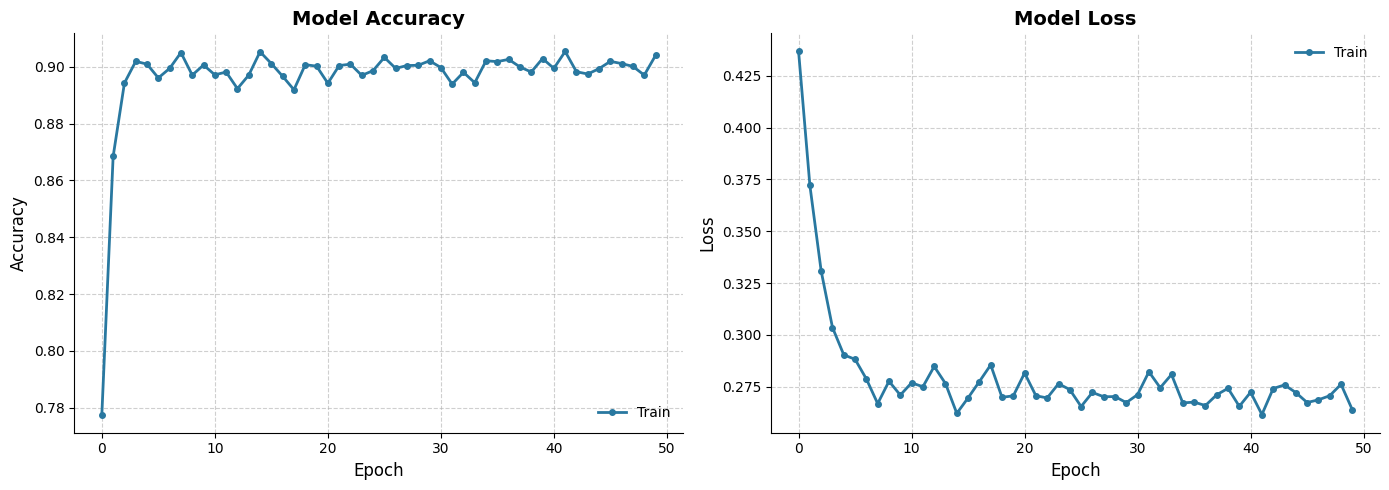

Model Performance Metrics:
--------------------------------------------------
Training Accuracy: 0.9996
Development Accuracy: 0.9842
Training Precision: 0.9487
Development Precision: 0.3571
Training Recall: 1.0000
Development Recall: 1.0000
Training F1 Score: 0.9737
Development F1 Score: 0.5263
--------------------------------------------------
Confusion Matrix (Training):
[[5048    2]
 [   0   37]]

Confusion Matrix (Development):
[[556   9]
 [  0   5]]


In [7]:
model, history = Build_and_Train(X_train, Y_train, version=1, epochs = EPOCHS, batch_size = BATCH_SIZE)
plot_model_history(history)
EvaluateNetwork(model, X_train, X_dev, Y_train, Y_dev)

Training...


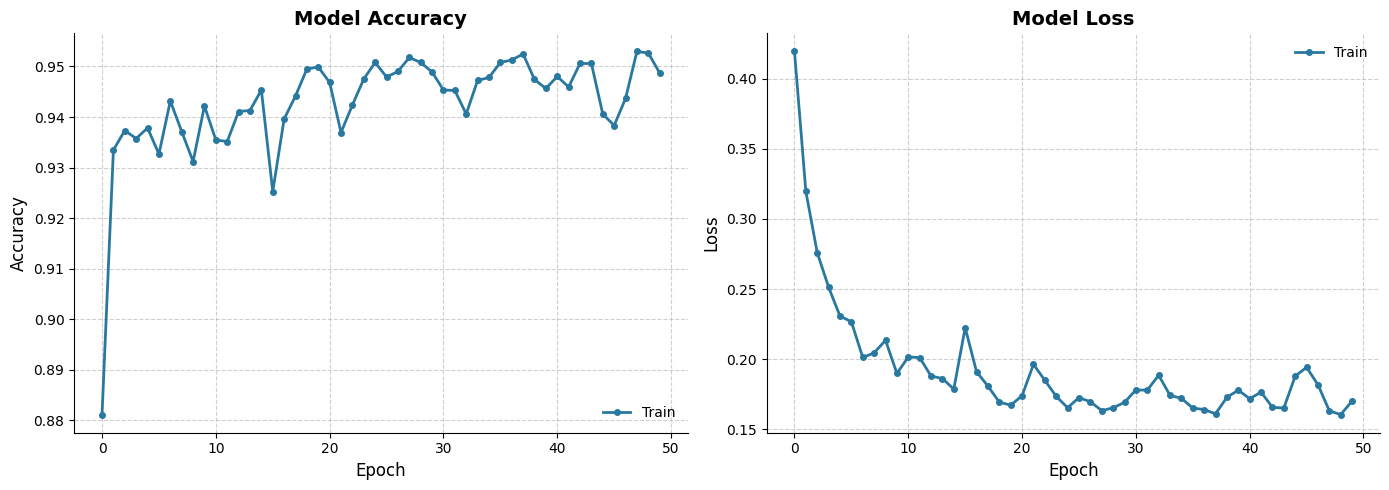

Model Performance Metrics:
--------------------------------------------------
Training Accuracy: 0.9984
Development Accuracy: 0.9912
Training Precision: 0.8222
Development Precision: 0.0000
Training Recall: 1.0000
Development Recall: 0.0000
Training F1 Score: 0.0000
Development F1 Score: 0.0000
--------------------------------------------------
Confusion Matrix (Training):
[[5042    8]
 [   0   37]]

Confusion Matrix (Development):
[[565   0]
 [  5   0]]


/Users/jacopocarotenuto/Documents/Università/Frati_Trappisti/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
model, history = Build_and_Train(X_train, Y_train, version=2, epochs = EPOCHS, batch_size = BATCH_SIZE)
plot_model_history(history)
EvaluateNetwork(model, X_train, X_dev, Y_train, Y_dev)

With 1 or 2 neurons it works, with 3 or more there is overfitting and cannot predict the ones with the planets.

## Training the Neural Network with the "Injected" Data

In [22]:
# Setup paths to data
train_dataset_path = "./Data/kepler/data_injected/exoTrain.csv"
dev_dataset_path = "./Data/kepler/data_injected/exoTest.csv"

In [23]:
X_train, Y_train, X_dev, Y_dev = Load_and_Process(train_dataset_path, dev_dataset_path)

Loading datasets...
Applying Fourier...
Normalizing...
Applying Gaussian Filter...
Standardizing...
Finished Processing!
Training examples: 5087
Feature dimension: 1598
Output dimension: 1


Training...


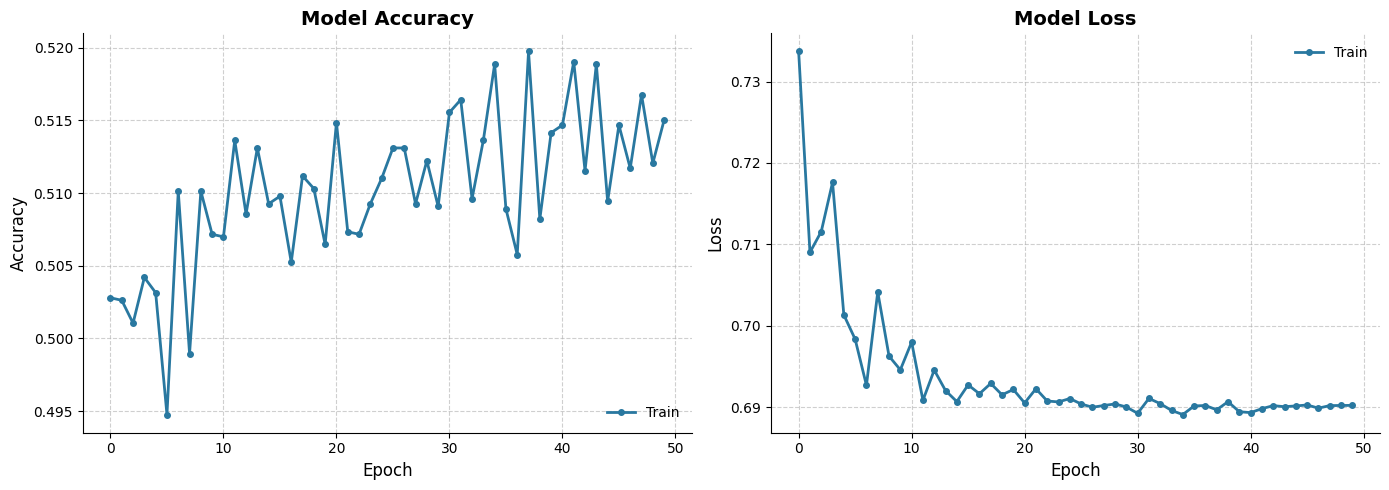

Model Performance Metrics:
--------------------------------------------------
Training Accuracy: 0.4901
Development Accuracy: 0.4456
Training Precision: 0.5855
Development Precision: 0.5000
Training Recall: 0.3195
Development Recall: 0.0949
Training F1 Score: 0.4134
Development F1 Score: 0.1596
--------------------------------------------------
Confusion Matrix (Training):
[[1579  647]
 [1947  914]]

Confusion Matrix (Development):
[[224  30]
 [286  30]]


In [24]:
model, history = Build_and_Train(X_train, Y_train, version=1, epochs = EPOCHS, batch_size = BATCH_SIZE)
plot_model_history(history)
EvaluateNetwork(model, X_train, X_dev, Y_train, Y_dev)

Training...


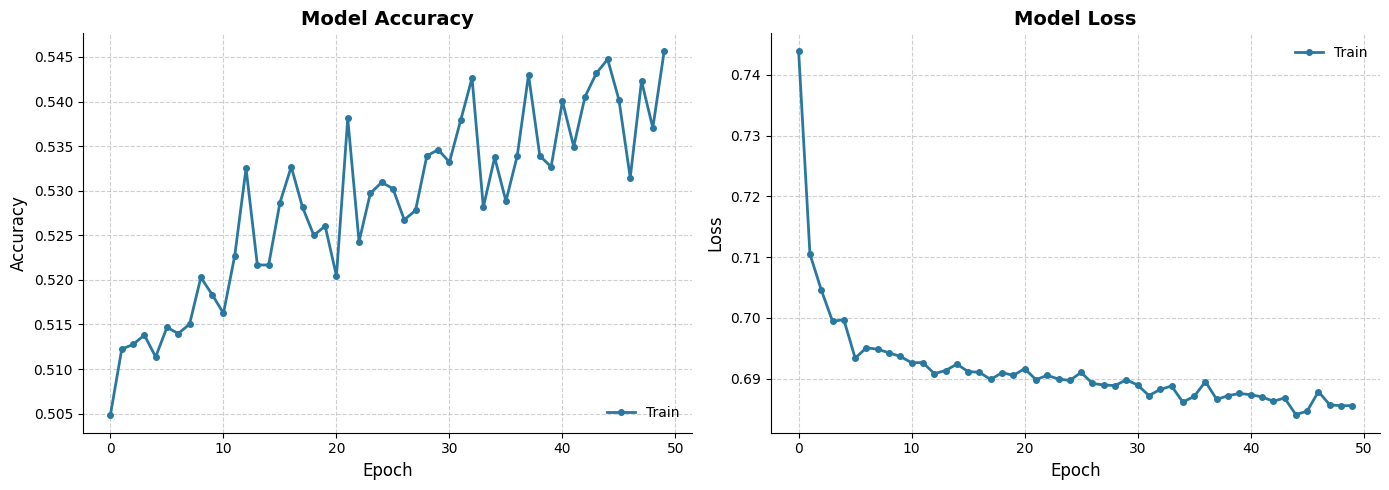

Model Performance Metrics:
--------------------------------------------------
Training Accuracy: 0.5630
Development Accuracy: 0.5667
Training Precision: 0.6130
Development Precision: 0.5680
Training Recall: 0.6050
Development Recall: 0.9114
Training F1 Score: 0.6090
Development F1 Score: 0.6999
--------------------------------------------------
Confusion Matrix (Training):
[[1133 1093]
 [1130 1731]]

Confusion Matrix (Development):
[[ 35 219]
 [ 28 288]]


In [36]:
model, history = Build_and_Train(X_train, Y_train, version=2, epochs=50, batch_size=32)
plot_model_history(history)
EvaluateNetwork(model, X_train, X_dev, Y_train, Y_dev)